In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


/home/strrl/Project/7375/assignment1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "code-review-dataset-full.xlsx"

df = pd.read_excel(file_path)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [6]:
print(model.device)

cpu


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

print(pipeline('This is a test text.'))

Device set to use cuda:0


[{'label': 'non-toxic', 'score': 0.9990898370742798}]


In [8]:
df = df.dropna(subset=['message','is_toxic'])
df['message'] = df['message'].astype(str)

In [9]:
def batch_predict(texts, batch_size=8):
    all_probs = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            non_toxic_probs = probs[:, 0]
            toxic_probs = 1 - non_toxic_probs
            all_probs.extend(toxic_probs)
    
    return all_probs

df["toxic_score"] = batch_predict(df["message"].tolist())

100%|██████████| 2456/2456 [00:14<00:00, 169.58it/s]


In [10]:
threshold = 0.5
df['pred_label'] = df['toxic_score'] > threshold

y_true = df["is_toxic"]
y_pred = df["pred_label"]
y_prob = df["toxic_score"]

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("ROC AUC:", roc_auc_score(y_true, y_prob))

precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

print("PR AUC:", pr_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     15890
           1       0.52      0.36      0.43      3757

    accuracy                           0.81     19647
   macro avg       0.69      0.64      0.66     19647
weighted avg       0.80      0.81      0.80     19647

ROC AUC: 0.8063992148576695
PR AUC: 0.44713920926420797


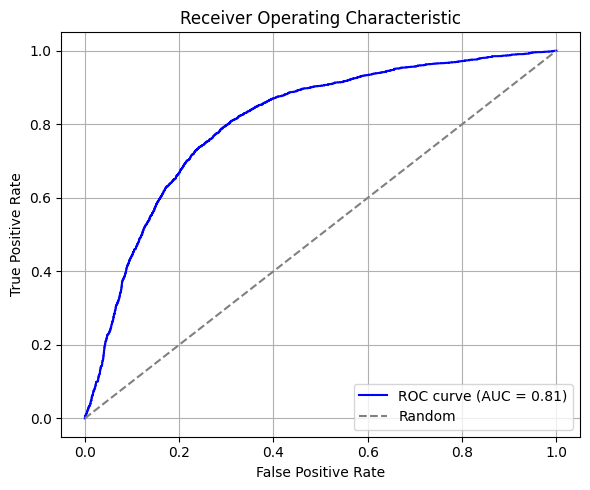

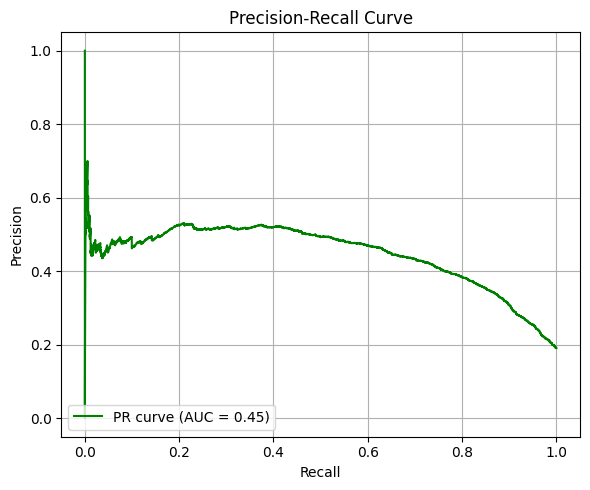

In [11]:
# ROC curve

import matplotlib.pyplot as plt

# get ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot PR curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

